In [1]:
import numpy as np
import pandas as pd
import spacy
from bidi.algorithm import get_display

from googletrans import Translator
translator = Translator()

# Test word vectors

In [3]:
vec_path = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/he_vectors'
nlp = spacy.load(vec_path)

In [4]:
doc = nlp("זהו טקסט בעברית.")
for token in doc:
    print(token.text, token.has_vector, token.vector_norm)

זהו True 1.0681664
טקסט True 0.8047567
בעברית True 0.40524793
. True 1.5317025


In [50]:
doc = nlp("חברה שלי פיפו לא אדום.")
for token in doc:
    print(token.text, token.has_vector, token.vector_norm)

חברה True 0.77420473
שלי True 1.0418928
פיפו True 0.0
לא True 1.9327171
אדום True 0.83313257
. True 1.5317025


# Search for similar words

## Arbitrary word

In [5]:
adom_id = nlp.vocab.strings['אדום']
adom_vec = nlp.vocab.vectors[adom_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([adom_vec]), n=5)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
words


['אדום', 'כחול', 'צהוב', 'ירוק', 'שחור']

In [6]:
adom_id = nlp.vocab.strings['אמרתי']
adom_vec = nlp.vocab.vectors[adom_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([adom_vec]), n=8)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
words

['אמרתי', 'ואמרתי', 'אגיד', 'חשבתי', 'ידעתי', 'שאמרתי', 'אומר', 'אמר']

## Test on LIP

In [7]:
lippath = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/LIPSTICK/hebrew_db.lip'
lip = pd.read_csv(lippath)
lip.set_index('word_ll', inplace=True, drop=False)

In [8]:
vec_path = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/he_vectors'
# Load your spaCy model that contains the Hebrew vectors
nlp = spacy.load(vec_path)

# Define the target word and process it to get its token (make sure it has a vector)
target_word = "עכביש"
target_token = nlp(target_word)[0]

other_words = lip.word_ll.values.tolist()  # List of words to compare with the target word
# Compute similarity for each word in the list
similarities = []
for word in other_words:
    token = nlp(word)[0]
    # Check if both tokens have vectors
    if target_token.has_vector and token.has_vector:
        sim = target_token.similarity(token)
        similarities.append((word, sim))
    else:
        similarities.append((word, 0.0))

# Sort words by similarity in descending order
similarities.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 most similar words
for word, score in similarities[:10]:
    print(f"{word}: {score:.3f}, {lip.loc[word, 'word_ul']}")


עכביש: 1.000, spider
קוף: 0.344, monkey
מפלצת: 0.316, monster
נחש: 0.286, snake
יצור: 0.260, creature
מכשפה: 0.259, witch
קוסם: 0.257, magician
מיקרופון: 0.254, microphone
טיפש: 0.251, Stupid
שריון: 0.251, armor


## Write word vectors

In [9]:
all_entries = lip.word_ll.values.tolist()
vect_word = []
vectors = []
for word in all_entries:
    token = nlp(word)[0]
    # Check if both tokens have vectors
    if target_token.has_vector and token.has_vector:
        vect_word.append(word)
        vectors.append(token.vector)

In [11]:
pathout = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/vectors_lip/vectors_heb_lip.npz'

np.savez(pathout, tokens=vect_word, vectors=vectors)

# Load word vectors from npz file

In [178]:
data = np.load(pathout)
tokens = data['tokens']
vectors = data['vectors']
token_to_vector = {token: vector for token, vector in zip(vect_word, vectors)}


In [190]:
specific_word = 'עכביש'
specific_vector = token_to_vector[specific_word]
similarities = []
norm = np.dot(specific_vector, specific_vector)
for word in tokens:
    token = token_to_vector[word]
    sim = np.dot(specific_vector, token) / norm
    similarities.append((word, sim))
similarities.sort(key=lambda x: x[1], reverse=True)
# Print the top 10 most similar words
for word, score in similarities[1:4]:
    print(f"{word}: {score:.3f}, {lip.loc[word, 'word_ul']}")

קוף: 0.659, monkey
חץ: 0.574, arrow
נחש: 0.503, snake


# EGGS: Functions to sample similar words

In [56]:
from random import sample

def load_similar_words(pathout, target_word):
    word_vectors = np.load(pathout)
    tokens = word_vectors['tokens']
    vectors = word_vectors['vectors']
    token_to_vector = {token: vector for token, vector in zip(tokens, vectors)}
    try:
        target_vector = token_to_vector[target_word]
    except IndexError as e:
        print(e, f' with {target_word}')
        return
    similarities = []

    norm = np.dot(target_vector, target_vector)
    for word in tokens:
        token = token_to_vector[word]
        sim = np.dot(target_vector, token) / norm
        similarities.append((word, sim))
    similarities.sort(key=lambda x: x[1], reverse=True)
    # return the top 3 most similar words
    return [word for word, _ in similarities[1:10]]

def sample_similar_options(lipstick_path : str, iquest : int, modality : str, n_options : int = 3):

    if modality == 'dt': word_lang = 'word_ul'
    elif modality == 'rt': word_lang = 'word_ll'
    else: print('Incorrect modality in rnd_options function')
    lip = pd.read_csv(lipstick_path)
    target_word = lip.iloc[iquest]['word_ll']
    lip = lip.set_index('word_ll', drop=False)
    options = {}
    #### Change this: to be extracted from lipstick_path:
    vector_path = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/vectors_lip/vectors_heb_lip.npz'
    similar_words = load_similar_words(vector_path, target_word=target_word)
    
    rnd_similar_words = sample(similar_words, n_options)
    print(rnd_similar_words)
    for i in range(n_options):
        rndOp = lip.loc[rnd_similar_words][word_lang]
        print(rndOp)
        # options[rndOp] = False
    return options


In [ ]:
vector_path = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/vectors_lip/vectors_heb_lip.npz'
load_similar_words(pathout=vector_path, target_word='עכביש')

['קוף', 'חץ', 'נחש', 'חכם', 'פשע', 'פחד', 'תת קרקעי', 'קוסם', 'מה אתה מסתכל']

In [201]:
iquest = 4
sample_similar_options(lipstick_path=lippath, iquest=iquest, modality='dt', n_options=4)

['נקי', 'מה נראה לך', 'רחב', 'יבש']
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object
word_ll
נקי                         net
מה נראה לך    What do you think
רחב                        wide
יבש                         dry
Name: word_ul, dtype: object


{}

# EGGS: Simple filtering out-of-bags words

## Drop words contained in original (simple prefixes and suffixes)

In [57]:
selected_word = 'להגיע'
# selected_word = get_display(selected_word)
selected_word_id = nlp.vocab.strings['להגיע']
sel_word_vec = nlp.vocab.vectors[selected_word_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([sel_word_vec]), n=5)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]

filtered_words = []
for w in words:
    if selected_word in w:
        print('Contained in original: ', w)
        continue
    filtered_words.append(w)
filtered_words

Contained in original:  להגיע
Contained in original:  ולהגיע


['להיכנס', 'לגשת', 'להתקרב']

## Account for different sofit letters (map to non-sofit)

In [15]:
def filter_sofits(word):
    from hebrew import FINAL_MINOR_LETTER_MAPPINGS as sofit_dict
    final_letter = word[-1]
    if final_letter in sofit_dict.keys():
        filtered_word = word[:-1] + sofit_dict[final_letter]
        return filtered_word
    else:
        return word

In [17]:
selected_word = 'מפלצת'
# selected_word = get_display(selected_word)
selected_word_id = nlp.vocab.strings[selected_word]
sel_word_vec = nlp.vocab.vectors[selected_word_id]
most_similar_words = nlp.vocab.vectors.most_similar(np.asarray([sel_word_vec]), n=30)
words = [nlp.vocab.strings[w] for w in most_similar_words[0][0]]
selected_filtered = filter_sofits(selected_word)
filtered_words = []
for w in words:
    wf = filter_sofits(w)
    if selected_filtered in wf:
        print('Contained in original: ', w)
        continue
    filtered_words.append(w)
filtered_words

Contained in original:  מפלצת
Contained in original:  המפלצת


['מפלצות',
 'חתולה',
 'חתול',
 'מכשפה',
 'דמות',
 'האמא',
 'רובוט',
 'ילדה',
 'מכונית',
 'תחפושת',
 'Monster',
 'בדיחה',
 'משוגע',
 'דרקון',
 'משאית',
 'נסיכה',
 'טירוף',
 'ציפור',
 'נאצי',
 'נערה',
 'גיהנום',
 'אגדה',
 'אמא',
 'סבתא',
 'ילדת',
 'חרא',
 'גיבור',
 'קופסה']

#### Reverse order: the most similar words are typically the ones with the same root, so not so interesting

In [193]:
filtered_words[::-1]

['נודעה',
 'נקראו',
 'הפך',
 'הוכר',
 'התפרסם',
 'בכינויו',
 'הוגדר',
 'הידוע',
 'נקראה',
 'שנודע',
 'הוחלף',
 'הקרוי',
 'שימש',
 'שנקרא',
 'כינה',
 'בכינוי',
 'כינויו',
 'כינו',
 'ונקרא',
 'כונו',
 'לכינוי',
 'קרוי',
 'כונתה',
 'נקרא']

#### Sampling randomly

In [196]:
from random import sample
sample(filtered_words, 5)

['ונקרא', 'נודעה', 'נקראו', 'כונתה', 'בכינוי']

# Advanced filtering OOB words

OOB: Out-of-bag

## With Google Translator API

In [128]:
import asyncio
from googletrans import LANGUAGES

from googletrans import Translator
translator = Translator()

In [19]:
translator = Translator()

# possible_words = sample(filtered_words, 5)
translations = await translator.translate(filtered_words, dest='en')
translated_words = [t.text for t in translations]
lang_detection = await translator.detect(translated_words)
detected_lang = [lang.lang for lang in lang_detection]

gota = pd.DataFrame(columns=['word_ll', 'word_ul', 'ui_language', 'learning_language'])
filtered_translations = []

for i, (word_ll, word_ul, detected_lang) in enumerate(zip(filtered_words, translated_words, detected_lang)):
    print(f"{i+1}")
    if detected_lang == translations[0].src:
        print(f"Failed to translate: {word_ll} -> {word_ul}")
        filtered_words.remove(word_ll)
        translated_words.remove(word_ul)
    else:
        print(f"Translation: {word_ll} -> {word_ul}")
        filtered_translations.append(word_ul)
gota['word_ll'] = filtered_words
gota['word_ul'] = filtered_translations
gota['ui_language'] = 'en'
gota['learning_language'] = 'iw'
gota

1
Translation: מפלצות -> Monsters
2
Translation: חתולה -> cat
3
Translation: חתול -> cat
4
Translation: מכשפה -> witch
5
Translation: דמות -> character
6
Translation: האמא -> The mom
7
Translation: רובוט -> robot
8
Translation: ילדה -> girl
9
Translation: מכונית -> car
10
Translation: תחפושת -> disguise
11
Translation: Monster -> Monster
12
Translation: בדיחה -> joke
13
Translation: משוגע -> crazy
14
Translation: דרקון -> dragon
15
Translation: משאית -> truck
16
Translation: נסיכה -> princess
17
Translation: טירוף -> Madness
18
Translation: ציפור -> A bird
19
Translation: נאצי -> Nazi
20
Translation: נערה -> girl
21
Translation: גיהנום -> hell
22
Translation: אגדה -> legend
23
Translation: אמא -> mother
24
Translation: סבתא -> grandmother
25
Translation: ילדת -> A girl
26
Translation: חרא -> Shit
27
Translation: גיבור -> Hero
28
Translation: קופסה -> box


,word_ll,word_ul,ui_language,learning_language
0,מפלצות,Monsters,en,iw
1,חתולה,cat,en,iw
2,חתול,cat,en,iw
3,מכשפה,witch,en,iw
4,דמות,character,en,iw
5,האמא,The mom,en,iw
6,רובוט,robot,en,iw
7,ילדה,girl,en,iw
8,מכונית,car,en,iw
9,תחפושת,disguise,en,iw


## Update bulkTranslate to new version (await)

In [20]:
gota

,word_ll,word_ul,ui_language,learning_language
0,מפלצות,Monsters,en,iw
1,חתולה,cat,en,iw
2,חתול,cat,en,iw
3,מכשפה,witch,en,iw
4,דמות,character,en,iw
5,האמא,The mom,en,iw
6,רובוט,robot,en,iw
7,ילדה,girl,en,iw
8,מכונית,car,en,iw
9,תחפושת,disguise,en,iw


In [75]:
from googletrans import LANGUAGES, LANGCODES

In [77]:
LANGCODES['hebrew']

'iw'

In [21]:
async def translate_text(src: pd.DataFrame, dest_lang: str):
    async with Translator() as translator:
        src_array = [w for w in src.word_ll.values]
        result = await translator.translate(src_array, src=src.learning_language.iloc[0], dest=src.ui_language.iloc[0])
        print([t.text for t in result])

In [22]:
async def bulk_translate(src: pd.DataFrame, dest_lang: str = None):
    async with Translator() as translator:
        src_list = [w for w in src.word_ll.values]
        if dest_lang == None:
            src.ui_language.iloc[0]
        result = await translator.translate(src_list, src=src.learning_language.iloc[0], dest=dest_lang)
        translated_words = [t.text for t in result]
        dest = pd.DataFrame({dest_lang: translated_words}, index=src_list, )
        return dest

In [23]:
await bulk_translate(gota, 'en')

,en
מפלצות,Monsters
חתולה,cat
חתול,cat
מכשפה,witch
דמות,character
האמא,The mom
רובוט,robot
ילדה,girl
מכונית,car
תחפושת,disguise


In [27]:
for w, tr in gota[['word_ll', 'word_ul']].values:
    print(w, tr)

מפלצות Monsters
חתולה cat
חתול cat
מכשפה witch
דמות character
האמא The mom
רובוט robot
ילדה girl
מכונית car
תחפושת disguise
Monster Monster
בדיחה joke
משוגע crazy
דרקון dragon
משאית truck
נסיכה princess
טירוף Madness
ציפור A bird
נאצי Nazi
נערה girl
גיהנום hell
אגדה legend
אמא mother
סבתא grandmother
ילדת A girl
חרא Shit
גיבור Hero
קופסה box


## Test network plotting

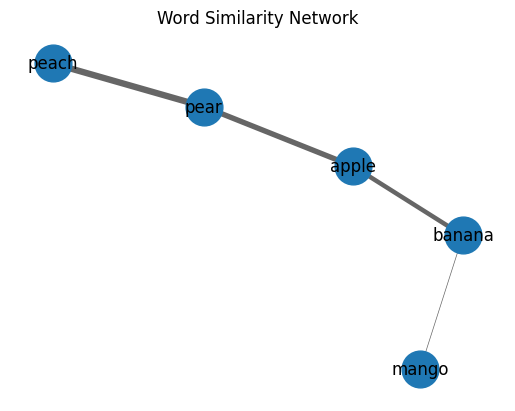

In [207]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. Build your graph
G = nx.Graph()
# Suppose you have a list of (word_a, word_b, similarity_score)
edges = [
    ('apple', 'pear', 0.78),
    ('apple', 'banana', 0.65),
    ('pear',  'peach', 0.92),
    ('banana','mango', 0.10),
]
# Add edges with a weight attribute
for a, b, w in edges:
    G.add_edge(a, b, weight=w)

# 2. Choose a layout
pos = nx.spring_layout(G, k=0.5)  # force‐directed layout

# 3. Draw nodes & edges
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos, font_size=12)
# scale edge widths by weight
weights = [G[u][v]['weight']*5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)

# 4. Show
plt.axis('off')
plt.title("Word Similarity Network")
plt.show()


# Test rebag_team

In [2]:
import pandas as pd
import numpy as np

In [39]:
def rebag_team(current_team: pd.DataFrame, team_lip_path: str):
    """Rebag function: return current_team to main lipstick and sample again for a new team"""
    
    dropped_rebag_team = current_team.drop(current_team[current_team['rebag'] == False].index)
    # print(f"team with dropped rebag = False: {dropped_rebag_team}")
    ##### This "test" is necessary to avoid an error of calling rebag_team in infinite loop when all entries are False
    try:
        print(dropped_rebag_team.index[0])

    except IndexError as e:
        ##### Return 0 allows continue_rebag_team to return to main menu
        print('All rebag entries in current team are False. No rebagging needed yet')
        return 0
    
    main_lip_path = team_lip_path.replace('_team', '')   # Extract main_lip_path from current_team
    main_lip = pd.read_csv(main_lip_path)                # Read main_lip
    main_lip.set_index('word_ul', inplace=True, drop=False)
    team_inds = current_team.index                       # Assign the current_team entries to main_lip and write
    main_lip.update(current_team)
    # main_lip.to_csv(main_lip_path, index=False)

    # Resample:
    new_team = main_lip.drop(main_lip[main_lip['rebag'] == True].index).head(6).copy()
    try:
        print(new_team.index[0])
    except IndexError as e:
        print('Main lipstick is fully rebagged. Resetting it')
        main_lip['rebag'] = False
        # main_lip.to_csv(main_lip_path, index=False)
        new_team = main_lip.drop(main_lip[main_lip['rebag'] == True].index).sample(6).copy()
        return new_team, 2
    
    return new_team

In [ ]:
def test_rebag_team():
    """Test function to check if rebag_team works"""
    teampath = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/LIPSTICK/hebrew_db_team.lip'
    lippath = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/LIPSTICK/hebrew_db.lip'
    teamlip = pd.read_csv(teampath)
    lip = pd.read_csv(lippath)
    faketeam = teamlip.copy()
    faketeam['rebag'] = True
    fakelip = lip.copy()
    fakelip['rebag'] = True
    fakelip.to_csv(lippath.replace('hebrew_db', 'fake_hebrew_db'))
    fakelippath = '/Users/pabloherrero/Documents/ManHatTan/mht/data/processed/LIPSTICK/fake_hebrew_db.lip'

    # Call the rebag_team function
    
    team_not_yet = rebag_team(teamlip, teampath)
    # Print the result
    print("Fresh new team after rebagging (should be zero):")
    print(team_not_yet)
    assert team_not_yet == 0

    team_rebag = rebag_team(faketeam, teampath)
    # Print the result
    print("Team ready for rebagging:")
    print(team_rebag)
    # Check if the new team is a DataFrame
    assert isinstance(team_rebag, pd.DataFrame)
    # Check if the new team has the same columns as the original team
    assert team_rebag.columns.tolist() == teamlip.columns.tolist()
    # Check if the new team has the same number of rows as the original team
    assert len(team_rebag) == len(faketeam)

    main_lip_finished, code = rebag_team(faketeam, fakelippath)
    # Print the result
    print("Main lip finished (fully rebagged):")
    print(main_lip_finished)
    # Check if the new team is a DataFrame
    assert isinstance(main_lip_finished, pd.DataFrame)
    assert code == 2
    

test_rebag_team()

All rebag entries in current team are False. No rebagging needed yet
Fresh new team after rebagging (should be zero):
0
0
creature
Team ready for rebagging:
          p_recall  n_id   timestamp  delta user_id learning_language  \
word_ul                                                                 
creature       0.0   511  1746629700      0   pablo                iw   
monster        0.0   335  1746629700      0   pablo                iw   
servant        0.0   170  1746629700      0   pablo                iw   
magician       0.0   215  1746629700      0   pablo                iw   
a hero         0.0   532  1746629700      0   pablo                iw   
helmet         0.0   574  1746629700      0   pablo                iw   

         ui_language word_ll   word_ul  \
word_ul                                  
creature          en    יצור  creature   
monster           en   מפלצת   monster   
servant           en    משרת   servant   
magician          en    קוסם  magician   
a hero

# Make EGG animation

In [2]:
from skimage.io import imread
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
from matplotlib.animation import FuncAnimation
import numpy as np

In [3]:
def to_transparent(img, bg_colors=[(255,255,255), (0,0,0)]):
    """Convert specified background colors to transparent."""
    if img.shape[2] == 4:
        rgba = img.copy()
    else:
        alpha = np.ones(img.shape[:2], dtype=img.dtype) * 255
        rgba = np.dstack([img, alpha])
    for color in bg_colors:
        mask = np.all(rgba[..., :3] == color, axis=-1)
        rgba[mask, 3] = 0
    return rgba

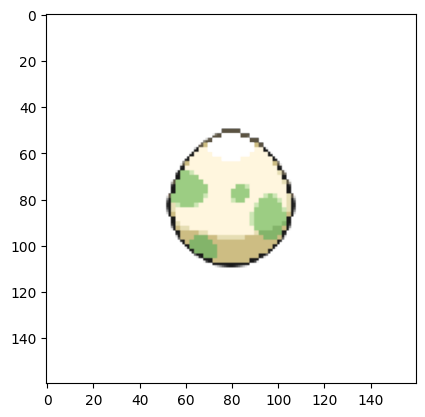

In [4]:
pathim = '/Users/pabloherrero/Documents/ManHatTan/mht/gui/Graphics/Battlers/egg.png'
img = imread(pathim)
img = to_transparent(img, bg_colors=[(255,255,255), (0,0,0)])  # Remove white and black
plt.imshow(img)

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(img)
ax.axis('off')

def animate(angle):
    # Rotate the image by 'angle' degrees
    rotated = rotate(img, angle, reshape=False, order=1)
    im.set_data(rotated)
    return [im]

ani = FuncAnimation(fig, animate, frames=np.linspace(-20, 20, 24), interval=10, blit=True, )
plt.close(fig)  # Prevents duplicate static image in Jupyter

from IPython.display import HTML
HTML(ani.to_jshtml())

In [73]:
frames = np.linspace(-20, 20, 24)
egg_animation = [rotate(img, a, reshape=False, order=1) for a in frames]

import os
from skimage.io import imsave


# Generate rotated frames
frames = np.linspace(-20, 20, 24)
egg_animation = [rotate(img, a, reshape=False, order=1, mode='constant', cval=0) for a in frames]

# Stack frames horizontally into a sprite sheet
sprite_sheet = np.concatenate(egg_animation, axis=1)

# Save the sprite sheet as a single PNG with transparency
output_path = '/Users/pabloherrero/Documents/ManHatTan/mht/gui/Graphics/Battlers/egg_sprite_sheet.png'
imsave(output_path, sprite_sheet.astype(np.uint8))